In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# загрузка датасета, удаление дубликатов и удаление id.
df = pd.read_csv('./wb_school_task_2.csv.gzip', compression='gzip')
df = df.drop(['id1', 'id2', 'id3'], axis = 1)

# Если длина отзыва > 135, то он большой.
BIG_REVIEW = 60

# Оставим валидацию
from sklearn.model_selection import train_test_split
len_test      = 0.2
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis = 1), df['label'], test_size=len_test, random_state=42, shuffle=True)
df = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

# Вступление

Самые популярные исследования изучают фэйковые отзывы на отели, рестораны, докторов (причём фейковые отзывы каждого продукта изучаются отдельно). И даже результаты редких исследований основанных на данных Amazon или Dianping нам могут не подойти, ибо фильтрация Wildberries может отличаться от фильтрации Amazon и Dianping. К тому же Россия отличается от США и Китая, поэтому мы будем проводить собственное исследование. Из научных статей мы будем брать все возможные идеи.

# Выбор классов моделей

Заметим, что предоставленный набор данных имеет маленький размер (3123 строчки), поэтому мы не можем использовать нейронные сети в качестве основного решения нашей ML задачи. В качестве основного решения мы будем использовать традиционные модели машинного обучения с учителем: SVM, NB, linear, random forest, gradientboosting. 



# Новые признаки отзыва
Нам были предоставленны следующие признаки отзыва:
- id1 -- 'id покупателя',
- id2 --'id товара',
- id3 -- 'id продавца',
- text-- 'text',
- f1 -- 'количество всех отзывов покупателя', 
- f2 -- 'количество уникальных поставщиков, которым писал отзывы покупатель',
- f3 -- 'средняя оценка покупателя', 
- f4 --'количество всех отзывов на товар', 
- f5 -- 'f5', 
- f6 -- 'средняя оценка товара', 
- f7 --'количество купленных товаров', 
- f8 --'количество заказанных товаров', 
- 'label'

### Behavioural feature (23 штуки)
1) Высокий процент положительных отзывов, написанных спамером о товарах может указывать на поддельные отзывы [1]. На эту фичу похожа f3.  
2) 75% спамеров создали более пяти отзывов в некоторые определенные дни [2]-[4]. Однако также было замечено, что 90% обычных пользователей никогда не писали более одного отзыва в течение одного дня.


In [ ]:
max_review = df['f1'].max()
df['beh2'] = np.vectorize(lambda x: x/max_review)(df['f1'])

3) Cпамеры не пишут подробных отзывов об услуге или продукте, что может помочь обнаружить спамеров [2]-[4]. Поскольку спамеры пытаются создать много фальшивых отзывов, поэтому они обычно тратят мало времени на написание своих отзывов. Однако 90% надежных рецензентов пишут более длинные отзывы со средней длиной более 200 слов.

In [ ]:
df['len_text'] = np.vectorize(len)(df['text']) # количество символов в тексте
df['beh3'] = np.vectorize(lambda x: 1 if len(x)>BIG_REVIEW else 0)(df['text'])
print ('Big Review -- %.3f' % (len(df[df['beh3'] == 1])/len(df)), '%')
print ('Smoll Review -- %.3f' % (len(df[df['beh3'] == 0])/len(df)), '%')

#### Если в данные добавить время написания отзыва и оценку отзыва, то можно добавить такие фичи:
1) Количество отзывов в сутки.
2) Отклонение оценки отзыва от средней оценки.
3) Чем раньше вышел отзыв, тем меньше вес имеет его оценка.
4) Процентное количество 1 звезд и 5 звёзд.
5) Доля первых отзывов на товары.

### Text feature (20 штук)
Текстовые фичи [8]:
- средняя длина слова
- количество символов верхнего регистра 

Морфологический разбор ухудшает точность модели.

In [ ]:
# определяет количество символов в верхнем регистре x
def upper(x):
    count_upper = 0
    for symbol in x:
        if symbol.isupper():
            count_upper += 1
    return count_upper

# средняя длина слова в x
def average_word(x): 
    sum_symbol = 0
    for word in x.split():
        sum_symbol += len(word)
    return sum_symbol/(len(x.split()))

In [ ]:
# количество символов в верхнем регистре
df['t19'] = df['text'].apply(upper)
# средннее количество символов в слове
df['t20'] = df['text'].apply(average_word)
# df = df.drop('text', axis = 1)

### Интересное замечание
В работе [1] было замечено, что Behavioural feature лучше, чем text фичи. text фичи бесполезны по отдельности, но могут быть полезны в группе.

# pre-trained GloVe embedding methods
Заметим, что наш датасет имеет малые размеры, поэтому мы не можем использовать нейронные сети для анализа текстов, поэтому алгоритмы по типу C-LSTM, HAN, convolutional HAN, и char-level C-LSTM нам не подойдут. Остаются только трансформеры
- BIDIRECTIONAL ENCODER REPRESENTATIONS FROM TRANSFORMERS (BERT) [5]
- DistilBERT [6]
- ROBUSTLY OPTIMIZED BERT APPROACH (RoBERTa) [7]

Из трансформеров интересно изучить DistilBERT (облегчённый BERT) и RoBerta (усиленный BERT). Однако эти трансформеры обучены на английском тексте, поэтому придётся искать их адаптацию на русский язык. В качестве DistilBERT возьмём rubert-tiny2, а в качаестве RoBerta возьмём universal-sentence-encoder-multilingual-large.

Мы видим, что выход universal-sentence-encoder-multilingual-large 512 символов, а rubert-tiny2 -- 312 символов. Для дообучения трансформера нужно настроить как минимум 312 параметров. Ограниченный датасет не позволяет нам использовать трансформер.

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()


def bert_embeding(x):
    return embed_bert_cls(x, model, tokenizer).reshape(1,312)



Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
df = pd.concat([df,pd.DataFrame(np.concatenate(df['text'].apply(bert_embeding).values), columns = ['emb'+str(i) for i in range(312)], index = df.index)], axis = 1)
df = df.drop(['text'], axis = 1)
df = df.drop_duplicates()
train = df

df = X_test
df['label'] = y_test
df = pd.concat([df,pd.DataFrame(np.concatenate(df['text'].apply(bert_embeding).values), columns = ['emb'+str(i) for i in range(312)], index = df.index)], axis = 1)
df = df.drop(['text'], axis = 1)
X_test = df.drop('label', axis = 1)
y_test = df['label']
df = train


0 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model



C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' arg


0 features with zero or negative importance after one-hot encoding.



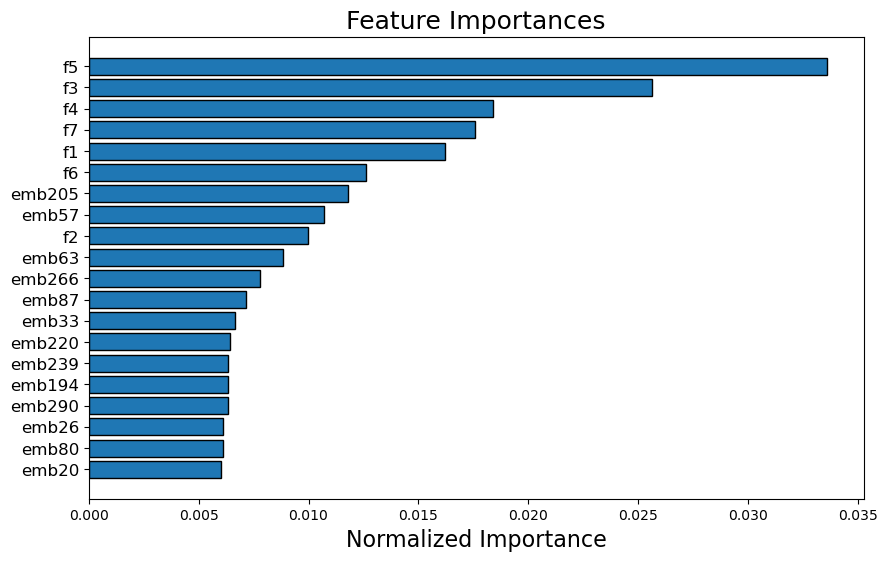

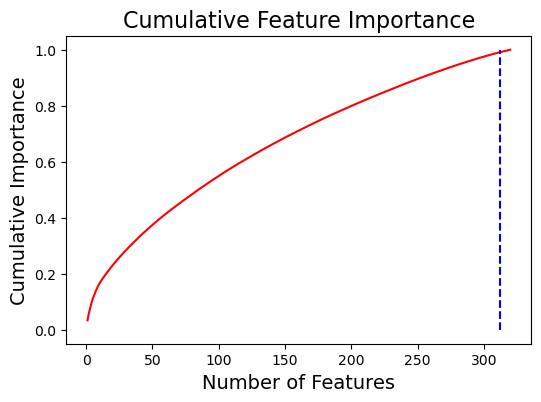

312 features required for 0.99 of cumulative importance


In [4]:
from feature_selector import FeatureSelector

# Признаки - в train, метки - в train_labels
fs = FeatureSelector(data = df.drop('label', axis = 1), labels = df['label'])

# Удаляем признаки с корреляцией 0.98
fs.identify_collinear(correlation_threshold = 0.98)

# Удаляем признаки с нулевой важностью
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'roc_auc', 
                            n_iterations = 10, 
                             early_stopping = True)

zero_importance_features = fs.ops['zero_importance']
%matplotlib inline
fs.plot_feature_importances(threshold = 0.99, plot_n = 20)
label = df['label']
# df = fs.remove(methods = 'all')
# df['label'] = label

Эксперементально было установлено, что лучшие фичи -- ['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'f8', 'beh2'] 

# Массовая генерация (+, *)

C:\Temp\ipykernel_14184\3796706222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns[_]+'+'+columns[__]] = df[columns[_]] + df[columns[__]]
C:\Temp\ipykernel_14184\3796706222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns[_]+'+'+columns[__]] = df[columns[_]] + df[columns[__]]
C:\Temp\ipykernel_14184\3796706222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

66 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model



C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' arg


0 features with zero or negative importance after one-hot encoding.



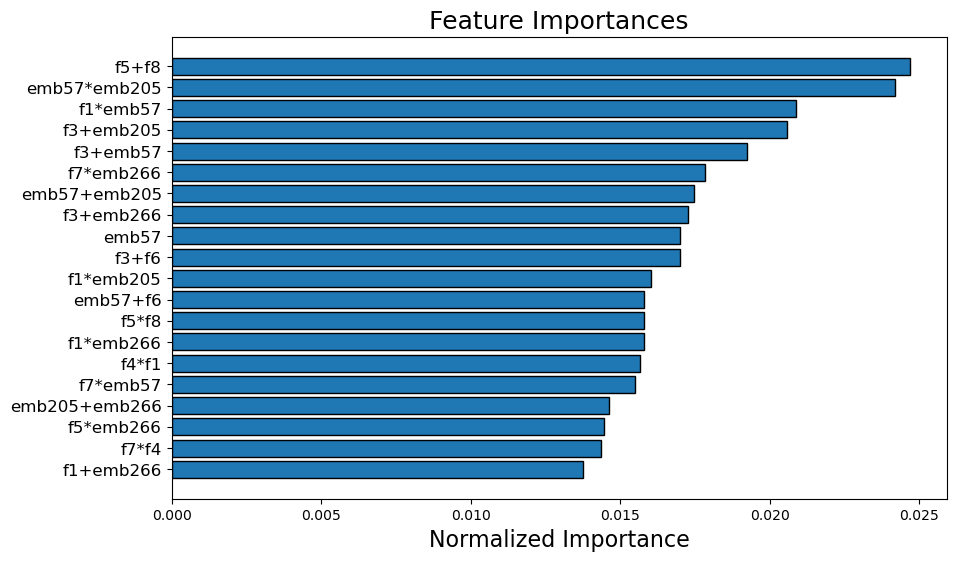

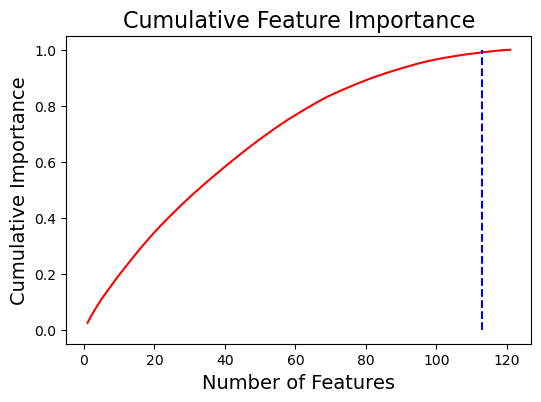

113 features required for 0.99 of cumulative importance


In [5]:
df = df[['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'f8', 'label']]
columns = df.columns.drop('label')
# складываем фичи
for _ in range (len(columns)):
    for __ in range(_+1, len(columns)):
        df[columns[_]+'+'+columns[__]] = df[columns[_]] + df[columns[__]]

# умножаем фичи
for _ in range (len(columns)):
    for __ in range(_+1, len(columns)):
        df[columns[_]+'*'+columns[__]] = df[columns[_]] * df[columns[__]]
        
        
# мнение lightboost
# Признаки - в train, метки - в train_labels
fs = FeatureSelector(data = df.drop('label', axis = 1), labels = df['label'])

# Удаляем признаки с корреляцией 0.98
fs.identify_collinear(correlation_threshold = 0.98)

# Удаляем признаки с нулевой важностью
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'roc_auc', 
                            n_iterations = 10, 
                             early_stopping = True)

zero_importance_features = fs.ops['zero_importance']
%matplotlib inline
fs.plot_feature_importances(threshold = 0.99, plot_n = 20)
df = df[['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'f8', 'emb57*emb205', 'label']]
X_test['emb57*emb205'] = X_test['emb57']*X_test['emb205']
X_test = X_test[['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'f8', 'emb57*emb205']]

При массовой генерации не заметно увеличение качество. Фича 'emb57*emb205' лидирует с отрывом, поэтому беру её в датасет

# EDA

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
for _ in df.columns:
    print(60*"--")
    plt.figure(figsize=(2,2))
    plt.text(0.5, 0.5, 'columns: '+_+ '\n'+ str(df[_].describe()), va='center', ha = 'right', fontsize=15)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
    plt.text(0.5, 0.5, 'Missing (%)   {:.2f}'.format(100*(len(df[_])-len(df[_].dropna()))/len(df[_])) + ' % \n' + 
             'Zeros (%)   {:.2f}'.format(100*len(df[_][df[_] == 0])/len(df[_])) + ' % \n' +
             'Unique (%)   {:.2f}'.format(100*len(df[_].unique())/len(df[_])) + '% \n',
             va='center', ha = 'right', fontsize=15)
    plt.axis('off')
    plt.show()

    if _ == 'text':
        tmp = df['text']
        fig = px.histogram( x = tmp.value_counts()[:10].index, y = tmp.value_counts()[:10].values)
        fig.show()
        continue
    fig = px.histogram(df[_])
    fig.show()
    fig = px.box(df[_])
    fig.show()
    print(60*"--")

In [ ]:
px.imshow(df.corr(), width=1000, height =1000)

# Основная метрика

Высокий (или низкий) рейтинг будет способствовать росту (или снижению) в продажах продукта, а увеличение среднего рейтинга на одну звезду способствует увеличению выручки на 5-9 процентов [9]. Ни одна стандартная метрика не имеет ничего общего с решением бизнес задачи. Однако невозможно ввести адекватную метрику, ибо мы не знаем оценок, которые были оставлены на товары, а значит можно барть любую метрику, например ROC-AUC.

# Определение бэйзлайна (KNN, Навиный Байес, SVM, Ridge, Logistic Regression, Random Forest, GradientBoosting)

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
tmp = cross_validate(clf, df.drop(['label'], axis = 1), df['label'], scoring=['roc_auc'], cv= 10, n_jobs=10, verbose = 0)['test_roc_auc']
print('test_roc_auc:',tmp)
print('')
print('test_mean:', tmp.mean())

# Наивный Байес 

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
tmp = cross_validate(clf, df.drop(['label'], axis = 1), df['label'], scoring=['roc_auc'], cv= 10, n_jobs=10, verbose = 0)['test_roc_auc']
print('test_roc_auc:',tmp)
print('')
print('test_mean:', tmp.mean())

# SVM

In [9]:
from sklearn import svm
clf = svm.SVC(probability=True)
tmp = cross_validate(clf, df.drop(['label'], axis = 1), df['label'], scoring=['roc_auc'], cv= 10, n_jobs=10, verbose = 0)['test_roc_auc']
print('test_roc_auc:',tmp)
print('')
print('test_mean:', tmp.mean())

test_roc_auc: [0.6955267  0.69476275 0.64255712 0.70320901 0.66767473 0.64121304
 0.68867608 0.70010081 0.61648746 0.6671787 ]

test_mean: 0.6717386383316768


# Ridge

In [ ]:
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier()
tmp = cross_validate(clf, df[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8'] ], df['label'], scoring=['roc_auc'], cv= 10, n_jobs=10, verbose = 0)['test_roc_auc']
print('test_roc_auc:',tmp)
print('')
print('test_mean:', tmp.mean())

# LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
tmp = cross_validate(clf, df.drop('label', axis = 1), df['label'], scoring=['roc_auc'], cv= 10, n_jobs=10, verbose = 0)['test_roc_auc']
print('test_roc_auc:',tmp)
print('')
print('test_mean:', tmp.mean())

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
tmp = cross_validate(clf, df.drop(['label'], axis = 1), df['label'], scoring=['roc_auc'], cv= 10, n_jobs=10, verbose = 0)['test_roc_auc']
print('test_roc_auc:',tmp)
print('')
print('test_mean:', tmp.mean())

# GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
tmp = cross_validate(clf, df.drop(['label'], axis = 1), df['label'], scoring=['roc_auc'], cv= 10, n_jobs=10, verbose = 0)['test_roc_auc']
print('test_roc_auc:',tmp)
print('')
print('test_mean:', tmp.mean())

# CatBoost

In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(verbose = 0)
tmp = cross_validate(clf, df.drop(['label'], axis = 1), df['label'], scoring=['roc_auc'], cv= 10, n_jobs=10, verbose = 0)['test_roc_auc']
print('test_roc_auc:',tmp)
print('')
print('test_mean:', tmp.mean())

- ['f5', 'f3', 'f1', 'f7', 'f4', 'f6', 'emb57', 'f2'] -- 0.7449671502683837
- ['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'emb290', 'f8', 'emb239'] -- 0.7570398452024993
- ['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'emb290', 'f8', 'emb239', 'emb94'] -- 0.754
- ['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'emb290', 'f8'] -- 0.7604655040168561
- ['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'f8'] -- 0.7622611119838942
- ['f5', 'f3', 'f7', 'f4', 'f1', 'emb57', 'f6', 'emb205', 'emb266', 'f2', 'f8', 'beh2'] -- 0.7632877958734813

In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(verbose = 0)
clf.fit(df.drop(['label'], axis = 1), df['label'])
tmp = pd.DataFrame(clf.feature_importances_.reshape(1,len(df.columns)-1), columns = df.drop('label', axis = 1).columns)
pd.DataFrame(tmp.to_numpy().reshape(len(tmp.columns),1), index = tmp.columns).sort_values(by = 0)[-20:]

# Бейзлайн

In [ ]:
roc_auc_score(y_test, np.zeros(625))

# Тюнинг гиперпараметров

## KNN

In [ ]:
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier
opt = BayesSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": space.Integer(1,100)
    },
    scoring = 'roc_auc',
    n_iter=50,
    verbose = 1,
    cv=10,
    n_jobs = 10
)

opt.fit(df.drop('label', axis = 1), df['label'])
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, opt.predict_proba(X_test)[:,1])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
print('roc_auc_score test' ,roc_auc_score(y_test, opt.predict_proba(X_test)[:,1]))

val. score: 0.6418203545775591

test score: 0.6729224309499539

best params: OrderedDict([('n_neighbors', 52)])

0.6729224309499539

## SVC

In [7]:
from skopt import BayesSearchCV, space, plots
from sklearn import svm
opt = BayesSearchCV(
    svm.SVC(),
    {
        'C': space.Real(1e-3, 1e+3, prior='log-uniform'),
        'gamma': space.Real(1e-4, 1e+4, prior='log-uniform'),
#         'degree': space.Integer(1,8),
        'probability': space.Categorical([True])
    },
    scoring = 'roc_auc',
    n_iter=50,
    verbose = 1,
    cv=5,
    n_jobs = 5
)

opt.fit(df.drop('label', axis = 1), df['label'])
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))
roc_auc_score(y_test, opt.predict_proba(X_test)[:,1])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
val. score: 0.6465727356359762
test score: 0.6829765545361874
best params: OrderedDict([('C', 0.6183283940558498), ('gamma', 0.0001), ('probability', True)])


0.6829765545361874

val. score: 0.6465727356359762

test score: 0.6829765545361874

best params: OrderedDict([('C', 0.6183283940558498), ('gamma', 0.0001), ('probability', True)])

## LogisticRegression

In [ ]:
from skopt import BayesSearchCV, space, plots
from sklearn.linear_model import LogisticRegression
opt = BayesSearchCV(
    LogisticRegression(),
    {
        'penalty' : ['l1', 'l2'],
        'C' : space.Real(1e-3, 1e+3, prior='log-uniform'),
        'solver' : ['liblinear']
    },
    scoring = 'roc_auc',
    n_iter=50,
    verbose = 1,
    cv=10,
    n_jobs = 10
)

opt.fit(df.drop('label', axis = 1), df['label'])
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, opt.predict_proba(X_test)[:,1])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
print('roc_auc_score test' ,roc_auc_score(y_test, opt.predict_proba(X_test)[:,1]))

val. score: 0.704648037224828

test score: 0.7238119508761711

best params: OrderedDict([('C', 11.288378916846883), ('penalty', 'l2'), ('solver', 'liblinear')])

## RandomForest

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\ProgramData\anaconda3\envs\FakeReviewTorch\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
val. score: 0.7491455567238299
test score: 0.7337265181301879
best params: OrderedDict([('max_depth', 8), ('n_estimators', 100)])
roc_auc_score test 0.7337265181301879


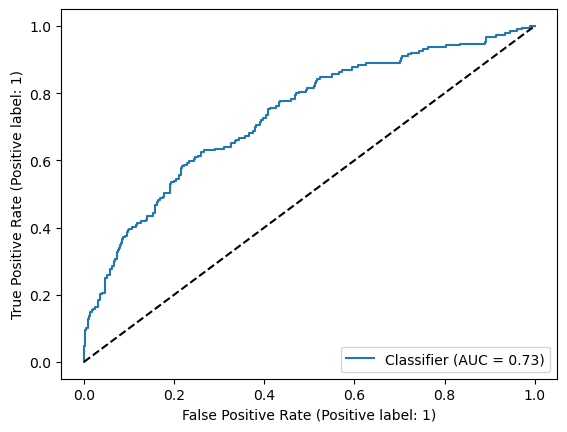

In [8]:
from skopt import BayesSearchCV, space, plots
from sklearn.ensemble import RandomForestClassifier
opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators' : space.Integer(10, 100),
        'max_depth' : space.Integer(4,10),
        
    },
    scoring = 'roc_auc',
    n_iter=50,
    verbose = 1,
    cv=10,
    n_jobs = 10
)

opt.fit(df.drop('label', axis = 1), df['label'])
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, opt.predict_proba(X_test)[:,1])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
print('roc_auc_score test' ,roc_auc_score(y_test, opt.predict_proba(X_test)[:,1]))

val. score: 0.7491455567238299

test score: 0.7337265181301879

best params: OrderedDict([('max_depth', 8), ('n_estimators', 100)])

## GradientBoostingClassifier

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

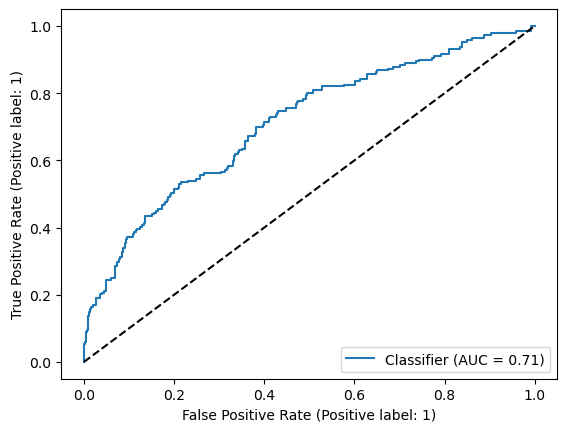

In [11]:
from skopt import BayesSearchCV, space, plots
from sklearn.ensemble import GradientBoostingClassifier
opt = BayesSearchCV(
    GradientBoostingClassifier(),
    {
        'learning_rate': space.Real(1e-5, 1, prior = 'log-uniform'),
        'max_depth' : space.Integer(4,10),
        'n_estimators': space.Integer(10,500)
    },
    scoring = 'roc_auc',
    n_iter=50,
    verbose = 1,
    cv=10,
    n_jobs = 10
)

opt.fit(df.drop('label', axis = 1), df['label'])
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, opt.predict_proba(X_test)[:,1])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
print('roc_auc_score test' ,roc_auc_score(y_test, opt.predict_proba(X_test)[:,1]))

val. score: 0.7481677822033017
    
test score: 0.710256783651279
    
best params: OrderedDict([('learning_rate', 0.08099979480911468), ('max_depth', 4), ('n_estimators', 278)])

## CatBoost

In [ ]:
from skopt import BayesSearchCV, space, plots
from catboost import CatBoostClassifier
opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'learning_rate': space.Real(1e-5, 1, prior = 'log-uniform'),
        'iterations': scpace.Integer(100,1000),
        'subsample': space.Real(0.05, 1),
        'max_depth': space.Integer(1, 10)
    },
    n_iter=30,
    verbose = 4,
    cv=3,
    n_jobs = 3,
    scoring = 'roc_auc'
)

opt.fit(df.drop('label', axis = 1), df['label'])
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, opt.predict_proba(X_test)[:,1])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

## LogisticRegression

val. score: 0.7555983247133448

test score: 0.7234114848793747

best params: OrderedDict([('iterations', 1000), ('learning_rate', 0.03917038821802146), ('max_depth', 4), ('subsample', 0.5711960500184257)])

# Победители

## LogisticRegression

val. score: 0.704648037224828

test score: 0.7238119508761711

best params: OrderedDict([('C', 11.288378916846883), ('penalty', 'l2'), ('solver', 'liblinear')])

roc_auc_score test 0.7238119508761711


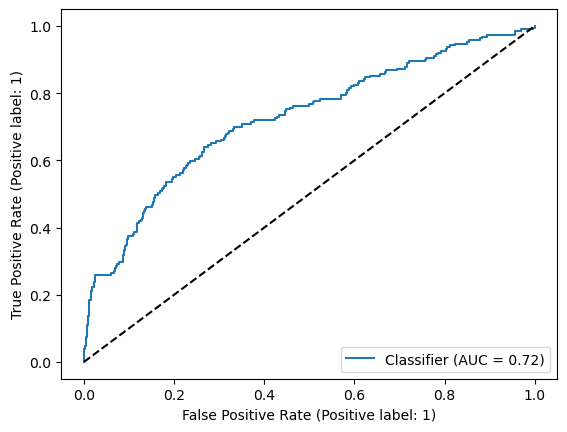

In [26]:
clf = LogisticRegression(C = 11.288378916846883, penalty = 'l2', solver = 'liblinear')
clf.fit(df.drop('label', axis = 1), df['label'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, clf.predict_proba(X_test)[:,1])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
print('roc_auc_score test' ,roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

## RandomForest

val. score: 0.7491455567238299

test score: 0.7337265181301879

best params: OrderedDict([('max_depth', 8), ('n_estimators', 100)])

roc_auc_score test 0.735425464783263


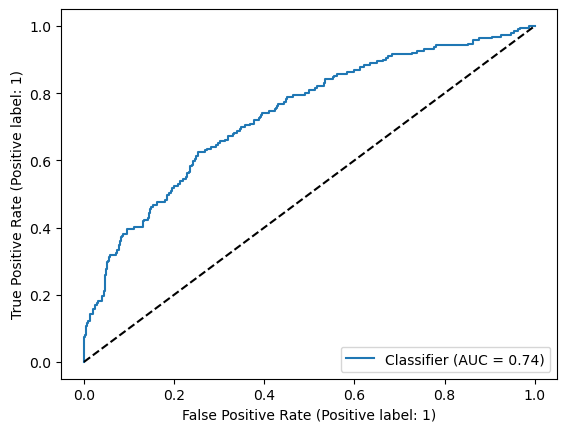

In [27]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = 8, n_estimators = 100)
clf.fit(df.drop('label', axis = 1), df['label'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, clf.predict_proba(X_test)[:,1])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
print('roc_auc_score test' ,roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

# Итоги
Ограниченный набор данных сильно связывает руки в решении ML задачи. Было бы здорово, если добавили время написания отзыва и оценку, поставленную за отзыв, тогда можно будет добавить большое количество Behavioural фичей, написать адекватную метрику для оптимизации. В качестве бейзлайна возьмём значение ROC-AUC -- 0.7495687120852556.

# Список литературы
- [1] F. H. Li, M. Huang, Y. Yang, and X. Zhu, ‘‘Learning to identify review spam,’’ in Proc. 22nd Int. Joint Conf. Artif. Intell., 2011, pp. 1–6.
- [2] H. Li, G. Fei, S. Wang, B. Liu, W. Shao, A. Mukherjee, and J. Shao, ‘‘Bimodal distribution and co-bursting in review spam detection,’’ in Proc. 26th Int. Conf. World Wide Web, Apr. 2017, pp. 1063–1072.
- [3]  Y. Li, ‘‘Highlighting the fake reviews in review sequence with the suspicious contents and behaviours,’’ J. Inf. Comput.al Sci., vol. 12, no. 4, pp. 1615–1627, Mar. 2015.
- [4] A. Mukherjee, A. Kumar, B. Liu, J. Wang, M. Hsu, M. Castellanos, and R. Ghosh, ‘‘Spotting opinion spammers using behavioral footprints,’’ in Proc. 19th ACM SIGKDD Int. Conf. Knowl. Discovery Data Mining, Aug. 2013, pp. 632–640.
- [5] J. Devlin, M.-W. Chang, K. Lee, and K. Toutanova, ‘‘BERT: Pretraining of deep bidirectional transformers for language understanding,’’ 2018, arXiv:1810.04805. [Online]. Available: http://arxiv.org/abs/1810. 04805
- [6]V. Sanh, L. Debut, J. Chaumond, and T. Wolf, ‘‘DistilBERT, a distilled version of BERT: Smaller, faster, cheaper and lighter,’’ 2019, arXiv:1910.01108. [Online]. Available: http://arxiv.org/abs/1910. 01108
- [7] Y. Liu, M. Ott, N. Goyal, J. Du, M. Joshi, D. Chen, O. Levy, M. Lewis, L. Zettlemoyer, and V. Stoyanov, ‘‘RoBERTa: A robustly optimized BERT pretraining approach,’’ 2019, arXiv:1907.11692. [Online]. Available: http://arxiv.org/abs/1907.11692
- [8]  S. Shojaee, M. A. A. Murad, A. B. Azman, N. M. Sharef, and S. Nadali,‘‘Detecting deceptive reviews using lexical and syntactic features,’’ in Proc. 13th Int. Conf. Intellient Syst. Design Appl., Dec. 2013, pp. 53–58.
- [9] Yingtong Dou, Guixiang Ma, Philip S. Yu, Sihong Xie, "Robust Spammer Detection by Nash Reinforcement Learning", 2020, 	arXiv:2006.06069. [Online]. Available: https://arxiv.org/abs/2006.06069